In [134]:
import polars as pl
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.preprocessing import StandardScaler
import torch
from torch_geometric.data import Data
import networkx as nx
import wandb


# Read data

In [121]:
df = pl.read_csv("D:\\PJATK_MGR\\bus_delay_project\\df_for_modelling_v2.csv", separator=";", schema_overrides={
    "line": pl.Utf8,
    "stop_id": pl.Int16,
    "stop_lat": pl.Float32,
    "stop_lon": pl.Float32,
    "stop_seq": pl.Int16,
    "arrival_hour": pl.Int8,
    "delay": pl.Int32,  
})[:20_000]

In [122]:
selected_columns = [
     "is_weekday",
    "arrival_hour",
    "is_holiday",
    "stop_lat",
    "stop_lon",
    "line_encoded",
    "stop_seq",
    "detection_type",
    "stop_id"
]

def preprocess_data(_df):
    _df = _df.drop_nulls()
    _df = _df.filter(pl.col("delay").is_between(-60*60, 60*60)) # drop extreme values

    _df = _df.with_columns(
        pl.col("is_weekday").cast(pl.Int8),
        pl.col("is_holiday").cast(pl.Int8),
    )

    unique_lines = _df.select("line").unique().sort("line").with_row_count(name="line_encoded")
    _df = _df.join(unique_lines, on="line", how="left")

    return _df

def prepare_training_data(_df):
    X_train_full = _df.select(selected_columns)
    X_train_full = X_train_full.to_numpy()
    y_train_full = _df.select(["delay"]).to_numpy()
    X_train, X_valid, y_train, y_valid = train_test_split(
    X_train_full, y_train_full, test_size=0.33, random_state=42)
    X_valid, X_test, y_valid, y_test = train_test_split(X_valid, y_valid, test_size=0.5, random_state=42)
    
    print("NaNs in X_train:", np.isnan(X_train).sum())
    print("Infs in X_train:", np.isinf(X_train).sum())
    print("NaNs in y_train:", np.isnan(y_train).sum())
    print("Infs in y_train:", np.isinf(y_train).sum())
    print("Delay extreme values:", df["delay"].min(), df["delay"].max())
    
    print(X_train.shape, y_train.shape, X_valid.shape, y_valid.shape)
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_valid = scaler.transform(X_valid)
    X_test = scaler.transform(X_test)
    return X_train, y_train, X_valid, y_valid, X_test, y_test
    

In [123]:
df = preprocess_data(df)
X_train, y_train, X_valid, y_valid, X_test, y_test = prepare_training_data(df)

C:\Users\48514\AppData\Local\Temp\ipykernel_18576\1517121747.py:22: DeprecationWarning: `DataFrame.with_row_count` is deprecated. Use `with_row_index` instead. Note that the default column name has changed from 'row_nr' to 'index'.
  unique_lines = _df.select("line").unique().sort("line").with_row_count(name="line_encoded")


NaNs in X_train: 0
Infs in X_train: 0
NaNs in y_train: 0
Infs in y_train: 0
Delay extreme values: -233 3329
(10158, 9) (10158, 1) (2502, 9) (2502, 1)


# Define graph structure

In [124]:
df = df.with_row_count(name="node_id") 

C:\Users\48514\AppData\Local\Temp\ipykernel_18576\3662015384.py:1: DeprecationWarning: `DataFrame.with_row_count` is deprecated. Use `with_row_index` instead. Note that the default column name has changed from 'row_nr' to 'index'.
  df = df.with_row_count(name="node_id")


In [125]:
df

node_id,date,line,task,stop_seq,stop_name,stop_id,scheduled_arrival,scheduled_departure,actual_arrival,actual_departure,detection_type,delay,stop_desc,stop_lat,stop_lon,is_weekday,arrival_hour,is_holiday,line_encoded
u32,str,str,str,i16,str,i16,str,str,str,str,i64,i32,str,f32,f32,i8,i8,i8,u32
0,"""2023-01-01T00:00:00.000000""","""10""","""010-01""",1,"""Władysława IV""",2169,"""2023-01-01T04:11:00.000000""","""2023-01-01T04:11:00.000000""","""2023-01-01T04:10:07.000000""","""2023-01-01T04:10:07.000000""",1,-53,"""Władysława IV""",54.398689,18.674339,0,4,1,0
1,"""2023-01-01T00:00:00.000000""","""10""","""010-01""",2,"""Nowy Port Góreckiego""",208,"""2023-01-01T04:12:00.000000""","""2023-01-01T04:12:00.000000""","""2023-01-01T04:12:12.000000""","""2023-01-01T04:12:44.000000""",2,12,"""Nowy Port Góreckiego""",54.400051,18.67098,0,4,1,0
2,"""2023-01-01T00:00:00.000000""","""10""","""010-01""",3,"""Marynarki Polskiej""",2166,"""2023-01-01T04:14:00.000000""","""2023-01-01T04:14:00.000000""","""2023-01-01T04:13:36.000000""","""2023-01-01T04:14:00.000000""",2,-24,"""Marynarki Polskiej""",54.398369,18.66617,0,4,1,0
3,"""2023-01-01T00:00:00.000000""","""10""","""010-01""",4,"""Śnieżna""",2164,"""2023-01-01T04:16:00.000000""","""2023-01-01T04:16:00.000000""","""2023-01-01T04:14:56.000000""","""2023-01-01T04:15:39.000000""",2,-64,"""Śnieżna""",54.392281,18.657669,0,4,1,0
4,"""2023-01-01T00:00:00.000000""","""10""","""010-01""",5,"""Polsat Plus Arena Gdańsk""",2162,"""2023-01-01T04:18:00.000000""","""2023-01-01T04:18:00.000000""","""2023-01-01T04:16:35.000000""","""2023-01-01T04:17:33.000000""",2,-85,"""Polsat Plus Arena Gdańsk""",54.38726,18.648399,0,4,1,0
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
15157,"""2023-01-01T00:00:00.000000""","""122""","""122-08""",15,"""Abrahama """,1794,"""2023-01-01T09:27:00.000000""","""2023-01-01T09:27:00.000000""","""2023-01-01T09:27:53.000000""","""2023-01-01T09:28:18.000000""",2,53,"""Abrahama """,54.392681,18.583549,0,9,1,12
15158,"""2023-01-01T00:00:00.000000""","""122""","""122-08""",17,"""Hala ""Olivia""""",1840,"""2023-01-01T09:29:00.000000""","""2023-01-01T09:29:00.000000""","""2023-01-01T09:30:53.000000""","""2023-01-01T09:31:28.000000""",2,113,"""Hala ""Olivia""""",54.401459,18.574169,0,9,1,12
15159,"""2023-01-01T00:00:00.000000""","""122""","""122-08""",18,"""Oliwa Pętla Tramwajowa""",1778,"""2023-01-01T09:32:00.000000""","""2023-01-01T09:32:00.000000""","""2023-01-01T09:32:57.000000""","""2023-01-01T09:33:27.000000""",2,57,"""Oliwa""",54.409199,18.568581,0,9,1,12


# Create edges based on stop sequences

In [126]:

groups = df.group_by(["date", "line_encoded", "task"])

edge_index = []

for group in groups.__iter__():
    grouping_key, group_df = group
    # print(grouping_key)
    group_df = group_df.sort("stop_seq")
    sorted_row_indices = group_df["node_id"].to_numpy()
    # print(group_df[["node_id", "line", "stop_seq", "scheduled_arrival", "task", "date"]].head(5))
    
    for i in range(len(sorted_row_indices) - 1):
        src = sorted_row_indices[i]
        dst = sorted_row_indices[i + 1]
        edge_index.append([src, dst])
    # print(edge_index)
    # break


In [127]:
import torch

edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()


In [142]:
# Store node features and labels
x = torch.tensor(df[selected_columns].to_numpy(), dtype=torch.float)
y = torch.tensor(df["delay"].to_numpy(), dtype=torch.float)

In [129]:
data = Data(x=x, edge_index=edge_index, y=y)


In [143]:
num_nodes = data.num_nodes
indices = torch.arange(num_nodes)

# Split 80% train, 20% validation
train_idx, val_idx = train_test_split(indices, test_size=0.2, random_state=42)

# Initialize masks
train_mask = torch.zeros(num_nodes, dtype=torch.bool)
val_mask = torch.zeros(num_nodes, dtype=torch.bool)

train_mask[train_idx] = True
val_mask[val_idx] = True

# Attach to data
data.train_mask = train_mask
data.val_mask = val_mask

# Visualize graph

C:\Users\48514\AppData\Local\Temp\ipykernel_18576\1983011796.py:35: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(plt.cm.ScalarMappable(cmap='coolwarm'), label="Delay (min)")


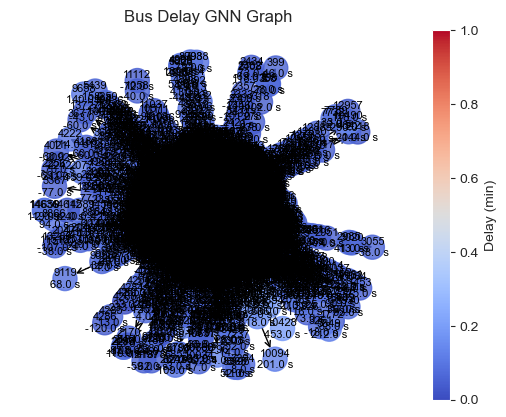

In [131]:
import networkx as nx
import matplotlib.pyplot as plt
from torch_geometric.utils import to_networkx

# Convert to NetworkX
G = to_networkx(data, to_undirected=False)

# Use spring layout or kamada_kawai for clearer spacing
pos = nx.spring_layout(G, seed=42)

# Example: color nodes by delay
node_colors = data.y.numpy()

# Example: custom labels, e.g., node ID + delay
node_labels = {i: f"{i}\n{delay:.1f} s" for i, delay in enumerate(data.y)}

# Draw nodes
nx.draw_networkx_nodes(G, pos,
                       node_color=node_colors,
                       cmap='coolwarm',  # choose any matplotlib colormap
                       alpha=0.8)

# Draw edges
nx.draw_networkx_edges(G, pos, arrowstyle='->', arrows=True)

# Draw custom node labels
nx.draw_networkx_labels(G, pos, labels=node_labels, font_size=8)

# (Optional) add edge labels
# edge_labels = {(u, v): f"{u}->{v}" for u, v in G.edges()}
# nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=7)

plt.title("Bus Delay GNN Graph")
plt.axis('off')
plt.colorbar(plt.cm.ScalarMappable(cmap='coolwarm'), label="Delay (min)")
plt.show()


# Model

In [144]:
run = wandb.init(
    # Set the wandb entity where your project will be logged (generally your team name).
    entity="dsc-pjatk-warsaw",
    # Set the wandb project where this run will be logged.
    project="bus-punctuality",
    # Track hyperparameters and run metadata.
    config={
        "learning_rate": 0.005,
        "architecture": "2 Layer GCN",
        "epochs": 15,
        "optimizer": "Adam",
        "train_size": X_train.shape[0],
    },
)

In [145]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

class GNNRegressor(nn.Module):
    def __init__(self, in_channels, hidden_channels=32):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, 1)  # Output = 1 for regression

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return x.view(-1)  # Return shape: [num_nodes]


In [146]:
model = GNNRegressor(in_channels=data.num_node_features)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
loss_fn = nn.MSELoss()

In [147]:
config = {
    "epochs": 200,
    "lr": 0.01,
    "hidden_channels": 32,
    "model": "GCN",
}

In [148]:

for epoch in range(config["epochs"]):
    model.train()
    optimizer.zero_grad()

    out = model(data)                  # Shape: [num_nodes]
    loss = loss_fn(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()

    # Evaluate on validation set
    model.eval()
    with torch.no_grad():
        val_out = model(data)
        val_loss = loss_fn(val_out[data.val_mask], data.y[data.val_mask])
        
    # log loss, val_loss, val_rmse, rmse
    wandb.log({
        "loss": loss.item(),
        "val_loss": val_loss.item(),
        "epoch": epoch,
        "rmse": torch.sqrt(loss).item(),
        "val_rmse": torch.sqrt(val_loss).item()
    })

    if epoch % 10 == 0:
        print(f"Epoch {epoch} | Train Loss: {loss.item():.4f} | Val Loss: {val_loss.item():.4f}")



Epoch 0 | Train Loss: 11386.4121 | Val Loss: 11777.8564
Epoch 10 | Train Loss: 8071.6592 | Val Loss: 8333.3623
Epoch 20 | Train Loss: 7074.6016 | Val Loss: 7903.5068
Epoch 30 | Train Loss: 6804.3716 | Val Loss: 7867.0293
Epoch 40 | Train Loss: 6789.8604 | Val Loss: 7885.4312
Epoch 50 | Train Loss: 6791.2871 | Val Loss: 7849.3062
Epoch 60 | Train Loss: 6762.7637 | Val Loss: 7861.6802
Epoch 70 | Train Loss: 6759.8877 | Val Loss: 7844.1436
Epoch 80 | Train Loss: 6755.4019 | Val Loss: 7838.9819
Epoch 90 | Train Loss: 6751.4761 | Val Loss: 7841.3242
Epoch 100 | Train Loss: 6748.6309 | Val Loss: 7835.6914
Epoch 110 | Train Loss: 6746.1958 | Val Loss: 7835.8062
Epoch 120 | Train Loss: 6743.9453 | Val Loss: 7832.7793
Epoch 130 | Train Loss: 6741.8149 | Val Loss: 7831.6533
Epoch 140 | Train Loss: 6739.7729 | Val Loss: 7829.8472
Epoch 150 | Train Loss: 6737.8047 | Val Loss: 7828.1387
Epoch 160 | Train Loss: 6735.8877 | Val Loss: 7826.7300
Epoch 170 | Train Loss: 6733.9990 | Val Loss: 7825.2065
E

In [149]:
run.finish()

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇███
loss,█▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▅▇█▂▃▁▁▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_rmse,█▅▄▂▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,199
loss,6728.42676
val_loss,7820.79248
val_rmse,88.43524
